# Imports

In [77]:
#pip install import_ipynb

In [1]:
import pandas as pd
import json
import import_ipynb
import matplotlib.pyplot as plt #visualizations
from datetime import datetime

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import seaborn as sns #visualizations

Modified invoice generator

In [2]:
import json
import random
import re
from datetime import datetime, timedelta
import numpy as np
from faker import Faker
import uuid
from collections import defaultdict
import copy

# Set up the Faker generator with a fixed seed for reproducibility
fake = Faker(['en_US'])

with open('synthetic_data_configs.json','r') as f:
    synthetic_data_configs = json.load(f)

def merchant_name_generator(merchant_types,company_suffixes):
            # Company Name Generator

    name_prefix = random.choice([
        fake.last_name(),
        fake.last_name() + " & " + fake.last_name(),
        fake.last_name() + "-" + fake.last_name(),
        fake.word().capitalize(),
        fake.word().capitalize() + fake.word().capitalize(),
    ])
    
    merchant_type = random.choice(merchant_types)
    suffix = random.choice(company_suffixes)
    
    merchant_name = [name_prefix]
    if random.random() >= 0.7:
        merchant_name.append(merchant_type)
    if random.random() >= 0.5:
        merchant_name.append(suffix)
    return (' '.join(merchant_name), merchant_type)

def generate_merchant_data(num_merchants=20):
    """
    Generate a diverse set of realistic merchant data
    
    Parameters:
    num_merchants (int): Number of merchants to generate
    
    Returns:
    list: List of merchant dictionaries
    """
    merchant_types = synthetic_data_configs["merchant_types"]
    company_suffixes = synthetic_data_configs["company_suffixes"]
    
    # ------------------------Modiefied------------------------------
    merchants = [{
    "name": "Curtis Instruments, Inc.",
    "merchant": "Curtis Instruments, Inc.",  # Add this line
    "address": "200 Kisco Avenue Mount Kisco NY 10549 USA",
    "city": "Mount Kisco",
    "state": "NY",
    "country": "US",
    "type": "Electronics"
    }]
    # ----------------------------------------------------------------
    
    # Create a set to track unique merchant names
    existing_names = {merchants[0]["name"]}
    
    # Generate additional merchants
    for _ in range(num_merchants - 1):
        country_code = 'US'
        
        fake.seed_instance(random.randint(1, 9999))
            
        # US address
        street = fake.street_address()
        city = fake.city()
        state = fake.state_abbr()
        zip_code = fake.zipcode()
        address = f"{street} {city} {state} {zip_code} USA"
        
        # Merchant Name Generator
        while True:
            merchant_name,merchant_type = merchant_name_generator(merchant_types, company_suffixes)

            # Check for uniqueness
            if merchant_name not in existing_names:
                existing_names.add(merchant_name)
                break
        
        merchants.append({
            "name": merchant_name,
            "address": address,
            "city": city,
            "state": state,
            "country": country_code,
            "type": merchant_type
        })
    
    return merchants

def generate_product_catalog():
    """
    Generate a realistic product catalog with categories and products
    
    Returns:
    dict: Dictionary mapping categories to lists of products
    """
    categories = synthetic_data_configs["categories"]
    
    # Generate product catalog
    catalog = {}
    
    for category, product_types in categories.items():
        catalog[category] = []
        
        # Generate 15-30 products per category
        for _ in range(random.randint(15, 30)):
            product_type = random.choice(product_types)
            
            # Generate model number
            model_prefix = ''.join(random.choice('ABCDEFGHJKLMNPQRSTUVWXYZ') for _ in range(random.randint(1, 3)))
            model_suffix = ''.join(random.choice('0123456789') for _ in range(random.randint(3, 5)))
            model = f"{model_prefix}-{model_suffix}"
            
            # Generate specification
            specs = [
                "Standard", "Premium", "Industrial", "Commercial", "Professional",
                "Heavy Duty", "Lightweight", "Compact", "Extended", "High Performance",
                "Economy", "Deluxe", "Ultimate", "Basic", "Advanced"
            ]
            spec = random.choice(specs)
            
            # Generate description
            description = f"{model} {spec} {product_type}"
            
            # Generate price based on category and specification
            base_price = {
                "Electronics": random.uniform(50, 500),
                "Industrial": random.uniform(100, 1000),
                "Office Supplies": random.uniform(10, 200),
                "Manufacturing": random.uniform(50, 800),
                "Automotive": random.uniform(30, 600),
                "Medical": random.uniform(100, 2000),
                "Construction": random.uniform(20, 500),
                "Technology": random.uniform(100, 3000),
                "Laboratory": random.uniform(50, 1500),
                "Engineering": random.uniform(100, 2000),
                "Aerospace": random.uniform(500, 5000),
                "Telecommunications": random.uniform(200, 2500)
            }[category]
            
            # Adjust price based on specification
            spec_multiplier = {
                "Standard": 1.0,
                "Premium": 1.5,
                "Industrial": 1.3,
                "Commercial": 1.2,
                "Professional": 1.4,
                "Heavy Duty": 1.3,
                "Lightweight": 0.9,
                "Compact": 0.85,
                "Extended": 1.25,
                "High Performance": 1.6,
                "Economy": 0.7,
                "Deluxe": 1.35,
                "Ultimate": 1.8,
                "Basic": 0.6,
                "Advanced": 1.5
            }[spec]
            
            unit_price = round(base_price * spec_multiplier, 2)
            
            catalog[category].append({
                "description": description,
                "unit_price": unit_price,
                "model": model,
                "spec": spec,
                "type": product_type
            })
    
    return catalog

def generate_synthetic_invoice(num_invoices=1, num_merchants=10, anomaly_rate=0.05):
    """
    Generate synthetic invoice data based on the provided schema
    
    Parameters:
    num_invoices (int): Number of synthetic invoices to generate
    num_invoices (int): Number of synthetic merchants to generate
    anomaly_rate (float): Rate at which to introduce data anomalies
    
    Returns:
    list: List of invoice dictionaries following the extraction schema
    """
    invoices = []
    
    # Generate merchant data
    merchants = generate_merchant_data(num_merchants)
    
    # Generate product catalog
    product_catalog = generate_product_catalog()
    
    # Define payment terms with weighted probabilities
    payment_terms = [
        ("NET 30 DAYS", 0.4),
        ("NET 45 DAYS", 0.2),
        ("NET 60 DAYS", 0.1),
        ("DUE ON RECEIPT", 0.15),
        ("2/10 NET 30", 0.05),
        ("COD", 0.05),
        ("NET 15 DAYS", 0.05)
    ]
    
    # Define payment methods
    payment_methods = {
        "shipping": ["UPS Ground", "FedEx Express", "FedEx Ground", "USPS Priority", "DHL Express"],
        "payment": ["Credit Card", "Wire Transfer", "ACH", "Check", "PayPal", "Net Banking"]
    }
    
    # Define currencies with correct format
    currencies = {
        "US": "USD",
    }
    
    # Define tax rates by state
    tax_rates = synthetic_data_configs["tax_rates"]
    
    # Customer data generation
    customers = []
    num_customers = min(num_invoices // 5, 50)  # Create a reasonable number of customers
    for _ in range(max(1, num_customers)):  # Ensure at least one customer
        customer = {
            "name": fake.company(),
            "customer_id": f"CUST-{random.randint(10000, 99999)}",
            "address": fake.address().replace('\n', ', '),
            "contact_person": fake.name(),
            "email": fake.company_email(),
            "phone": fake.phone_number()
        }
        customers.append(customer)
    
    # Create a distribution of invoices where some merchants and customers appear more often
    # This mimics real world patterns where certain suppliers are used more frequently
    merchant_weights = np.random.exponential(scale=1.0, size=len(merchants))
    merchant_weights = merchant_weights / np.sum(merchant_weights)
    
    customer_weights = np.random.exponential(scale=1.0, size=len(customers))
    customer_weights = customer_weights / np.sum(customer_weights)
    
    # Track merchant-customer relationships to create realistic patterns
    merchant_customers = defaultdict(list)
    
    # Track invoice numbers by merchant
    merchant_invoice_counters = {m["name"]: 1 for m in merchants}
    
    # po_records = {} ####
    
    # Generate invoice data
    for invoice_idx in range(num_invoices):
        # Select merchant with weighted probability
        merchant = np.random.choice(merchants, p=merchant_weights)
        merchant_name = merchant["name"]
        merchant_address = merchant["address"]
        merchant_type = merchant["type"]
        city = merchant["city"]
        state = merchant["state"]
        country = merchant["country"]
        currency = currencies[country]
        
        # Generate realistic invoice number
        invoice_prefix = ''.join(random.choice(merchant_name.split()[0:1]).upper()[0:3])
        invoice_year = datetime.now().year
        invoice_num = merchant_invoice_counters[merchant_name]
        merchant_invoice_counters[merchant_name] += 1
        invoice_number = f"{invoice_prefix}{invoice_year}-{invoice_num:05d}"
        
        # Generate invoice date (weighted toward recent dates)
        days_ago = int(np.random.exponential(scale=60))  # Mostly recent invoices
        days_ago = min(days_ago, 365)  # Cap at 1 year
        invoice_date = datetime.now() - timedelta(days=days_ago)
        
        # Format date according to country conventions
        if country in ['US', 'CA']:
            invoice_date_str = invoice_date.strftime("%m/%d/%Y")
        else:
            invoice_date_str = invoice_date.strftime("%d/%m/%Y")
        
        # Select payment term with weighted probability
        payment_term = random.choices([term[0] for term in payment_terms], 
                                     weights=[term[1] for term in payment_terms])[0]
        
        # Calculate due date based on payment terms
        if "30" in payment_term:
            due_days = 30
        elif "45" in payment_term:
            due_days = 45
        elif "60" in payment_term:
            due_days = 60
        elif "15" in payment_term:
            due_days = 15
        elif "RECEIPT" in payment_term or "COD" in payment_term:
            due_days = 0
        else:  # Default for 2/10 NET 30 or other formats
            due_days = 30
            
        due_date = invoice_date + timedelta(days=due_days)
        
        # Format due date according to country conventions
        if country in ['US', 'CA']:
            due_date_str = due_date.strftime("%m/%d/%Y")
        else:
            due_date_str = due_date.strftime("%d/%m/%Y")
        
        # Select or create a customer relationship
        if merchant_name in merchant_customers and random.random() < 0.8:
            # 80% chance to use an existing customer for this merchant
            customer = random.choice(merchant_customers[merchant_name])
        else:
            # Either new merchant or 20% chance to add a new customer
            customer = np.random.choice(customers, p=customer_weights)
            merchant_customers[merchant_name].append(customer)
        
        # Generate PO number with several realistic formats
        po_formats = [
            f"{random.randint(10000, 99999)}-{random.randint(100, 999)}",
            f"PO-{random.randint(10000, 99999)}",
            f"{customer['customer_id']}-{random.randint(1000, 9999)}",
            f"{datetime.now().strftime('%y%m')}-{random.randint(1000, 9999)}",
            f"{random.randint(100000, 999999)}",
            f"{random.choice('ABCDEFGHJKLMNPQRSTUVWXYZ')}{random.randint(10000, 99999)}"
        ]
        po_number = random.choice(po_formats)
        
        # Determine payment method based on merchant type and customer patterns
        if random.random() < 0.7:  # 70% chance it's a shipping method
            payment_method = random.choice(payment_methods["shipping"])
        else:  # 30% chance it's an actual payment method
            payment_method = random.choice(payment_methods["payment"])
        
        # Generate line items
        line_items = []
        
        # Number of items follows a distribution centered on 3-4 items
        num_items_distribution = [0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02]
        num_items = np.random.choice(range(1, len(num_items_distribution) + 1), 
                                    p=num_items_distribution)
        
        # For some merchants, force at least 2 line items to mimic bundled purchases
        if random.random() < 0.3 and num_items == 1:
            num_items = 2
        
        # Select products from appropriate category for merchant type
        available_products = product_catalog.get(merchant_type, [])
        if not available_products:  # Fallback if category doesn't match
            available_products = random.choice(list(product_catalog.values()))
        
        # Select products without replacement if possible
        selected_products = random.sample(available_products, 
                                         min(num_items, len(available_products)))
        
        # If we need more products than unique ones available, allow repeats
        if num_items > len(selected_products):
            additional_products = [random.choice(available_products) 
                                  for _ in range(num_items - len(selected_products))]
            selected_products.extend(additional_products)
        
        # Calculate tax rates based on country and region
        tax_rate = tax_rates.get(state, 0.0)
        
        # Handle special case for shipping
        shipping_cost = 0
        if random.random() < 0.4:  # 40% chance of separate shipping charge
            shipping_cost = round(random.uniform(5, 50), 2)
        
        subtotal = 0
        total_tax = 0
        
        # Collect line details in the expected format
        formatted_line_details = []
        
        # Generate each line item
        for i, product in enumerate(selected_products, 1):
            description = product["description"]
            unit_price = product["unit_price"]
            
            # Generate quantity with realistic distribution
            qty_distribution = {
                1: 0.3,   # 30% chance of qty 1
                2: 0.2,   # 20% chance of qty 2
                3: 0.1,   # 10% chance of qty 3
                4: 0.05,  # 5% chance of qty 4
                5: 0.05,  # 5% chance of qty 5
                10: 0.1,  # 10% chance of qty 10
                12: 0.05, # 5% chance of qty 12
                24: 0.05, # 5% chance of qty 24
                50: 0.05, # 5% chance of qty 50
                100: 0.05 # 5% chance of qty 100
            }
            
            qty = random.choices(list(qty_distribution.keys()), 
                               weights=list(qty_distribution.values()))[0]
            
            # Calculate line total with realistic price adjustments
            # Occasionally apply discounts for bulk purchases
            discount = 1.0
            if qty >= 10:
                discount = random.uniform(0.85, 0.95)
            elif qty >= 50:
                discount = random.uniform(0.75, 0.85)
            
            # Apply slight random variance to unit price
            adjusted_unit_price = unit_price * random.uniform(0.98, 1.02) * discount
            line_total = round(adjusted_unit_price * qty, 2)
            
            # Calculate line tax
            line_tax = round(line_total * tax_rate, 2) if tax_rate > 0 else 0.0
            
            # ------------------------Modiefied------------------------------
            # Added
            def apply_variations(line_details):
                for line in line_details:
                    if "line_description" not in line:  # Add key check
                        continue
                        
                    base_product = next(
                        (k for k, v in synthetic_data_configs["product_variations"].items()
                        if line["line_description"].startswith(k)  # Key fix
                    ), None)
                    
                    if base_product:
                        variation = random.choice(
                            synthetic_data_configs["product_variations"][base_product]
                        )
                        line["line_description"] = variation + " " + line["line_description"].split(" ", 1)[-1]
                return line_details        
            
            label = 0 ### added
            # For anomalies, occasionally introduce incorrect calculations
            if random.random() < anomaly_rate * 0.3:  # 30% of anomalies
                duplicated_product = random.choice(selected_products)
                selected_products.insert(i, duplicated_product)
                label = 1 ### added
                
            # For anomalies, occasionally introduce duplicate varied wordings
            if random.random() < anomaly_rate * 0.3:  # 30% of anomalies
                # Get all invoices from the same merchant
                merchant_invoices = [
                    inv for inv in invoices 
                    if any(ext["field"] == "merchant" and ext["value"] == merchant_name 
                        for ext in inv["extractions"])
                ]
                
                if merchant_invoices:
                    base_invoice = random.choice(merchant_invoices)
                    duplicate_invoice = copy.deepcopy(base_invoice)
                    original_date = datetime.strptime(
                        duplicate_invoice["invoice_date"], "%m/%d/%Y")
                    new_date = original_date + timedelta(days=random.randint(1, 30))
                    duplicate_invoice["invoice_date"] = new_date.strftime("%m/%d/%Y")
                    
                    # Modify line item descriptions
                    duplicate_invoice["line_details"] = apply_variations(
                        duplicate_invoice["line_details"]
                    )
                    invoices.append(duplicate_invoice)
                label = 1 ### added
                
            if random.random() < anomaly_rate:
                anomaly_type = random.choice(['tax_calc', 'line_total', 'skip_tax', 'negative_qty', 'price_mismatch'])
                if anomaly_type == 'tax_calc':
                    line_tax = round(line_total * random.uniform(0.05, 0.25), 2)
                elif anomaly_type == 'line_total':
                    # Slightly off multiplication
                    line_total = round(adjusted_unit_price * qty * random.uniform(0.9, 1.1), 2)
                elif anomaly_type == 'skip_tax':
                    line_tax = 0.0
                elif anomaly_type == 'negative_qty':
                    qty = -abs(qty)
                elif anomaly_type == 'price_mismatch':
                    catalog_price = product["unit_price"]
                    deviation = random.uniform(0.5, 2.0)
                    adjusted_unit_price = catalog_price * deviation
                label = 1 ### added
            
            # Add line details to our formatted output
            formatted_line_details.append({
                "line_count": str(i),
                "line_description": description,
                "line_qty": str(qty),
                "line_tax": "{:.2f}".format(line_tax),
                "line_total": "{:.2f}".format(line_total),
                "model": product["model"]  # Add this line
            })
            # ---------------------------------------------------------------
            
            # Add to running totals
            subtotal += line_total
            total_tax += line_tax
        
        # Calculate grand total
        grand_total = subtotal + total_tax + shipping_cost
        
        # State label => 1 if state not in the dictionary or country != "US"
        if (state not in tax_rates) or (country != "US"):
            state_label = 1
        else:
            state_label = 0
        
        # ------------------------Modiefied------------------------------    
        # Create formatted invoice following the schema
        formatted_invoice = {
            "invoice_id": f"INV-{uuid.uuid4().hex[:8].upper()}",
            "invoice_date": invoice_date_str,  # Added this
            "extractions": [
                {"field": "merchant", "value": merchant_name},
                {"field": "invoice_date", "value": invoice_date_str},
                {"field": "merchant_branch", "value": merchant_name},  # Using same value as merchant
                {"field": "merchant_chain", "value": merchant_name},   # Using same value as merchant
                {"field": "due_date", "value": due_date_str},
                {"field": "payment_terms", "value": payment_term},
                {"field": "grand_total", "value": "{:.2f}".format(grand_total)},
                {"field": "tax", "value": "{:.2f}".format(total_tax)},
                {"field": "po_number", "value": po_number},
                {"field": "merchant_address", "value": merchant_address.replace(',', '')},
                {"field": "payment_method", "value": payment_method},
                {"field": "country", "value": country},
                {"field": "currency", "value": currency},
                {'field': 'tax_label', 'value': label}, ###
                {"field": "line_details", "value": formatted_line_details},
                {"field": "state_label", "value": state_label}  ### state anomaly feature
            ],
            "line_details": formatted_line_details
        }
        # --------------------------------------------------------------
        
        invoices.append(formatted_invoice)
    
    # po_records[po_number].append({"merchant": merchant_name, "grand_total": grand_total})
    
    return invoices

def analyze_synthetic_data(invoices):
    """
    Analyze the generated synthetic data
    
    Parameters:
    invoices (list): List of invoice dictionaries
    """
    # Count merchants
    merchants = set()
    countries = set()
    total_value = 0
    line_items_count = 0
    
    for invoice in invoices:
        extractions = {item["field"]: item["value"] for item in invoice["extractions"]}
        
        if "merchant" in extractions:
            merchants.add(extractions["merchant"])
        
        if "country" in extractions:
            countries.add(extractions["country"])
        
        if "grand_total" in extractions:
            try:
                total_value += float(extractions["grand_total"])
            except ValueError:
                pass
        
        if "line_details" in extractions:
            line_items = extractions["line_details"]
            if isinstance(line_items, list):
                line_items_count += len(line_items)
    
    print(f"Analysis of {len(invoices)} invoices:")
    print(f"- Unique merchants: {len(merchants)}")
    print(f"- Total line items: {line_items_count}")
    print(f"- Average line items per invoice: {line_items_count/len(invoices):.2f}")
    
    # Count frequency of fields
    field_counts = defaultdict(int)
    for invoice in invoices:
        for item in invoice["extractions"]:
            field_counts[item["field"]] += 1
    
    print("\nField frequency:")
    for field, count in sorted(field_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = count / len(invoices) * 100
        print(f"- {field}: {count} ({percentage:.1f}%)")

def save_synthetic_data(invoices, base_filename="synthetic_invoices2"): #change filename here ###
    """   
    Parameters:
    invoices (list): List of invoice dictionaries
    base_filename (str): Base filename without extension
    """
    # Save all invoices to one file
    all_filename = f"{base_filename}.json"
    with open(all_filename, 'w') as f:
        json.dump(invoices, f, indent=2)
    
    print(f"Generated {len(invoices)} synthetic invoices and saved to {all_filename}")
    
    # Save in JSONL format as well (one invoice per line, no indentation)
    jsonl_filename = f"{base_filename}.jsonl"
    with open(jsonl_filename, 'w') as f:
        for invoice in invoices:
            f.write(json.dumps(invoice) + '\n')
    
    print(f"Saved invoices in JSONL format to {jsonl_filename}")

# Main function to generate invoices
def generate_dataset(num_invoices=100, num_merchants=1000, anomaly_rate=0.05, seed=42):
    """
    Generate a complete synthetic invoice dataset
    
    Parameters:
    num_invoices (int): Number of invoices to generate
    anomaly_rate (float): Rate of anomalies to introduce
    seed (int): Random seed for reproducibility
    
    Returns:
    list: Generated invoices
    """
    # Set random seeds
    random.seed(seed)
    np.random.seed(seed)
    Faker.seed(seed)
    
    print(f"Generating {num_invoices} synthetic invoices across a set of {num_merchants} merchants (anomaly rate: {anomaly_rate:.1%})...")
    invoices = generate_synthetic_invoice(num_invoices, num_merchants, anomaly_rate)
    
    # Analyze the generated data
    analyze_synthetic_data(invoices)
    
    # Save the data
    save_synthetic_data(invoices)
    
    return invoices

Functions

In [3]:
def json_to_df(filename):
    '''
    converts json string from json file to pd dataframe
    '''
    with open(filename) as file:
        data = json.load(file)

    formatted_data = []
    for item in data:
        row = {entry["field"]: entry["value"] for entry in item["extractions"]}
        formatted_data.append(row)

    df = pd.DataFrame(formatted_data)
    return df

In [4]:
def string_to_df(json_string):
    '''
    converts json string to pd dataframe
    '''
    formatted_data = []
    for item in json_string:
        row = {entry["field"]: entry["value"] for entry in item["extractions"]}
        formatted_data.append(row)

    df = pd.DataFrame(formatted_data)
    return df

# Data

In [6]:
data = generate_dataset(num_invoices=100,num_merchants=100) #creates json in synthetic_invoices.json

Generating 100 synthetic invoices across a set of 100 merchants (anomaly rate: 5.0%)...
Analysis of 100 invoices:
- Unique merchants: 44
- Total line items: 347
- Average line items per invoice: 3.47

Field frequency:
- merchant: 100 (100.0%)
- invoice_date: 100 (100.0%)
- merchant_branch: 100 (100.0%)
- merchant_chain: 100 (100.0%)
- due_date: 100 (100.0%)
- payment_terms: 100 (100.0%)
- grand_total: 100 (100.0%)
- tax: 100 (100.0%)
- po_number: 100 (100.0%)
- merchant_address: 100 (100.0%)
- payment_method: 100 (100.0%)
- country: 100 (100.0%)
- currency: 100 (100.0%)
- tax_label: 100 (100.0%)
- line_details: 100 (100.0%)
- state_label: 100 (100.0%)
Generated 100 synthetic invoices and saved to synthetic_invoices2.json
Saved invoices in JSONL format to synthetic_invoices2.jsonl


In [7]:
df1 = json_to_df('synthetic_invoices.json') # puts synthetic_invoices.json into df

In [8]:
df1 = string_to_df(data) # 

In [9]:
df1

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,merchant_address,payment_method,country,currency,tax_label,line_details,state_label
0,DreamFight,10/31/2024,DreamFight,DreamFight,12/30/2024,NET 60 DAYS,8710.72,472.89,49478-456,6037 Lewis Field Apt. 013 Port Amberfurt OH 82...,DHL Express,US,USD,0,"[{'line_count': '1', 'line_description': 'SDU-...",0
1,OfficerThan,02/10/2025,OfficerThan,OfficerThan,03/12/2025,NET 30 DAYS,13487.75,793.40,PO-69394,7831 Robert Centers Apt. 306 Robertsview MA 66...,UPS Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'W-00...",0
2,Walker,02/01/2025,Walker,Walker,03/03/2025,NET 30 DAYS,166072.40,8804.71,2503-5597,421 Robert Glens North Meganburgh AZ 73492 USA,FedEx Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'WTU-...",0
3,Jones & Wilson,02/19/2025,Jones & Wilson,Jones & Wilson,02/19/2025,DUE ON RECEIPT,41669.12,2543.19,PO-66113,1910 Booth Roads Suite 855 Lake Andrea WA 9291...,PayPal,US,USD,0,"[{'line_count': '1', 'line_description': 'FR-1...",0
4,Baker,01/02/2025,Baker,Baker,03/03/2025,NET 60 DAYS,104976.10,6265.81,Q84760,052 Allen Trafficway Nicholasbury CT 49123 USA,USPS Priority,US,USD,0,"[{'line_count': '1', 'line_description': 'V-27...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Hayes-Watson Electronics,01/22/2025,Hayes-Watson Electronics,Hayes-Watson Electronics,02/21/2025,NET 30 DAYS,62521.95,3538.98,PO-60967,93449 Hawkins Islands East Stacey IA 88619 USA,UPS Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'MCS-...",0
96,Martin-Kaiser LLC,02/23/2025,Martin-Kaiser LLC,Martin-Kaiser LLC,02/23/2025,DUE ON RECEIPT,7203.21,0.00,39068-444,21837 Douglas Cliffs Suite 259 North Melissapo...,FedEx Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'X-90...",1
97,Give,03/15/2025,Give,Give,04/14/2025,NET 30 DAYS,47272.62,0.00,M57367,5356 Pham Parkway Apt. 703 North Andrew MT 468...,PayPal,US,USD,0,"[{'line_count': '1', 'line_description': 'AHM-...",0
98,MatterSouthern,11/02/2024,MatterSouthern,MatterSouthern,12/02/2024,NET 30 DAYS,14323.96,810.80,N74884,48515 Jay Islands Apt. 470 West Emily MI 80341...,DHL Express,US,USD,0,"[{'line_count': '1', 'line_description': 'XT-1...",0


In [143]:
df1['tax']

0       472.89
1       793.40
2      8804.71
3      2543.19
4      6265.81
        ...   
95     3538.98
96        0.00
97        0.00
98      810.80
99    12553.33
Name: tax, Length: 100, dtype: object

In [5]:
data2 = generate_dataset(num_invoices=10000,num_merchants=10000)
product_catalog = generate_product_catalog()
model_price_map = {
    product["model"]: product["unit_price"]
    for category in product_catalog.values()
    for product in category
}

Generating 10000 synthetic invoices across a set of 10000 merchants (anomaly rate: 5.0%)...
Analysis of 10247 invoices:
- Unique merchants: 4990
- Total line items: 35486
- Average line items per invoice: 3.46

Field frequency:
- merchant: 10247 (100.0%)
- invoice_date: 10247 (100.0%)
- merchant_branch: 10247 (100.0%)
- merchant_chain: 10247 (100.0%)
- due_date: 10247 (100.0%)
- payment_terms: 10247 (100.0%)
- grand_total: 10247 (100.0%)
- tax: 10247 (100.0%)
- po_number: 10247 (100.0%)
- merchant_address: 10247 (100.0%)
- payment_method: 10247 (100.0%)
- country: 10247 (100.0%)
- currency: 10247 (100.0%)
- tax_label: 10247 (100.0%)
- line_details: 10247 (100.0%)
- state_label: 10247 (100.0%)
Generated 10247 synthetic invoices and saved to synthetic_invoices2.json
Saved invoices in JSONL format to synthetic_invoices2.jsonl


In [20]:
df2 = string_to_df(data2)

In [21]:
df2

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,merchant_address,payment_method,country,currency,tax_label,line_details,state_label
0,Barry,02/11/2025,Barry,Barry,02/11/2025,DUE ON RECEIPT,40151.83,1957.59,CUST-68053-2248,141 Hodges Mountains Kramerville NM 04216 USA,UPS Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'LEU-...",0
1,Macdonald-Patterson Office Supplies International,02/09/2025,Macdonald-Patterson Office Supplies International,Macdonald-Patterson Office Supplies International,03/11/2025,NET 30 DAYS,1379.79,0.00,E51230,57081 Wilkinson Cove East David OR 03013 USA,UPS Ground,US,USD,0,"[{'line_count': '1', 'line_description': 'DDR-...",0
2,Sawyer Laboratory,02/25/2025,Sawyer Laboratory,Sawyer Laboratory,03/27/2025,NET 30 DAYS,19064.09,862.35,CUST-86692-5475,193 Ryan Lodge Suite 052 West Sylviachester NC...,USPS Priority,US,USD,0,"[{'line_count': '1', 'line_description': 'QSM-...",0
3,Stark-Church Enterprises,03/04/2025,Stark-Church Enterprises,Stark-Church Enterprises,03/04/2025,COD,17749.24,1003.62,P43535,413 James Roads Bakerville IA 12699 USA,FedEx Express,US,USD,0,"[{'line_count': '1', 'line_description': 'BD-3...",0
4,Bond Corp.,12/26/2024,Bond Corp.,Bond Corp.,02/24/2025,NET 60 DAYS,5097.44,326.79,CUST-70023-1595,746 Michael Trafficway Michelleburgh NV 02384 USA,DHL Express,US,USD,0,"[{'line_count': '1', 'line_description': 'KSZ-...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10242,Ramirez-Krause,09/30/2024,Ramirez-Krause,Ramirez-Krause,09/30/2024,COD,3037.47,136.32,N16383,7918 Kayla Valleys Marcusberg NC 51818 USA,USPS Priority,US,USD,0,"[{'line_count': '1', 'line_description': 'HVQ-...",0
10243,Becker & Tran Co.,01/02/2025,Becker & Tran Co.,Becker & Tran Co.,02/01/2025,NET 30 DAYS,6900.85,396.75,CUST-86692-8572,3746 Tina Unions Apt. 258 New Cindy UT 52683 USA,DHL Express,US,USD,0,"[{'line_count': '1', 'line_description': 'H-57...",0
10244,Gill Office Supplies,01/08/2025,Gill Office Supplies,Gill Office Supplies,02/07/2025,NET 30 DAYS,649.67,0.00,CUST-47406-6307,490 Taylor Points Apt. 894 East Christophermou...,DHL Express,US,USD,0,"[{'line_count': '1', 'line_description': 'F-35...",0
10245,Powell Aerospace Co.,03/06/2025,Powell Aerospace Co.,Powell Aerospace Co.,04/05/2025,NET 30 DAYS,6036.49,314.70,CUST-32660-5798,730 Christopher Divide Murphytown NE 08002 USA,USPS Priority,US,USD,0,"[{'line_count': '1', 'line_description': 'HJK-...",0


In [ ]:
#df2.to_excel("output.xlsx", index=False)

In [22]:
df2.describe()

,tax_label,state_label
count,10247.000000,10247.000000
mean,0.058163,0.144628
std,0.234064,0.351742
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


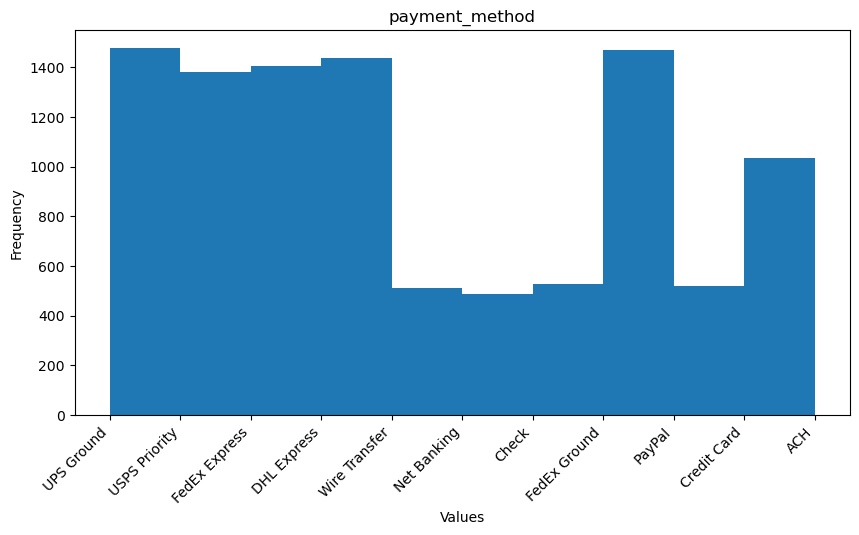

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(df2['payment_method'], bins=10)
plt.title('payment_method')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.show()

In [24]:
date_format = "%m/%d/%Y"

df2['invoice_date'] = df2['invoice_date'].apply(lambda x: datetime.strptime(x, date_format) )
df2['due_date'] =  df2['due_date'].apply(lambda x: datetime.strptime(x, date_format) )

In [25]:
df2['time to pay'] = df2['due_date'] - df2['invoice_date']

In [26]:
df2['tax'] = df2['tax'].astype(float)
df2['grand_total'] = df2['grand_total'].astype(float)

In [27]:
df2['tax_rate'] = df2['tax']/df2['grand_total']

In [28]:
### FROM CATHERINE'S CODE

# Function to extract state from address (format: "Street, City, State ZIP, Country")
def extract_state(address):
    match = re.search(r'\b[A-Z]{2}\b', address)  # Match two-letter state codes
    return match.group(0) if match else None

# Apply state extraction
df2["state"] = df2["merchant_address"].apply(extract_state)

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import hashlib

def feature_engineering2(invoice_df, product_catalog, model_price_map):
    """
    Create features for anomaly detection in invoices
    """
    # Copy dataframe to avoid modifying original
    df = invoice_df.copy()
    
    # Convert string dates to datetime
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    
    # 1. Basic Aggregations
    # ----------------------------
    df['total_line_items'] = df['line_details'].apply(len)
    df['total_quantity'] = df['line_details'].apply(
        lambda x: sum(int(line['line_qty']) for line in x)
    )
    df['avg_line_price'] = df['line_details'].apply(
        lambda x: np.mean([float(line['line_total']) for line in x])
    )
    
    # 2. Duplicate Detection Features
    # ----------------------------
    def detect_duplicates(lines):
        """Identify duplicate line items using description hashing"""
        hashes = []
        for line in lines:
            # Create hash of normalized description
            clean_desc = line.get('line_description', '').lower().replace(" ", "")
            line_hash = hashlib.md5(clean_desc.encode()).hexdigest()
            hashes.append(line_hash)
        return sum(pd.Series(hashes).value_counts() > 1)
    
    df['duplicate_line_items'] = df['line_details'].apply(detect_duplicates)
    
    # 3. Tax Anomaly Features
    # ----------------------------
    def calculate_tax_discrepancy(row):
        """Compare actual tax vs expected tax based on state rate"""
        try:
            state_tax_rate = synthetic_data_configs["tax_rates"][row['state']]
            expected_tax = row['subtotal'] * state_tax_rate
            return abs(row['tax'] - expected_tax)
        except KeyError:
            return 0
    
    df['tax_discrepancy'] = df.apply(calculate_tax_discrepancy, axis=1)
    
    # 4. Price Deviation Features
    # ----------------------------
    def calculate_price_deviation(lines):
        """Compare line prices to product catalog"""
        deviations = []
        for line in lines:
            model = line.get('model')
            catalog_price = model_price_map.get(model, None)
            if catalog_price and line['line_qty'] != '0':
                expected = float(line['line_qty']) * catalog_price
                deviations.append(abs(float(line['line_total']) - expected))
        return np.mean(deviations) if deviations else 0
    
    df['price_deviation'] = df['line_details'].apply(calculate_price_deviation)
    
    # 5. Negative Quantity Detection
    # ----------------------------
    df['has_negative_qty'] = df['line_details'].apply(
        lambda x: any(int(line['line_qty']) < 0 for line in x)
    ).astype(int)
    
    # 6. Bulk Purchase Detection
    # ----------------------------
    q_99 = df['total_quantity'].quantile(0.99)
    df['bulk_purchase'] = (df['total_quantity'] > q_99).astype(int)
    
    # 7. Temporal Features
    # ----------------------------
    # Days since last invoice from same merchant
    df = df.sort_values('invoice_date')
    df['days_since_last'] = df.groupby('merchant')['invoice_date'].diff().dt.days
    
    # Weekend invoice flag
    df['weekend_invoice'] = df['invoice_date'].dt.dayofweek >= 5
    
    # 8. Semantic Duplicate Detection
    # ----------------------------
    vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    
    # Track description history per merchant
    merchant_history = defaultdict(list)
    df['description_similarity'] = 0.0
    
    for idx, row in df.iterrows():
        current_desc = " ".join([line['line_description'] for line in row['line_details']])
        merchant = row['merchant']
        
        if merchant in merchant_history and merchant_history[merchant]:
            # Compare with last 3 invoices
            previous_descs = merchant_history[merchant][-3:]
            vectors = vectorizer.fit_transform([current_desc] + previous_descs)
            similarities = cosine_similarity(vectors[0:1], vectors[1:])[0]
            df.at[idx, 'description_similarity'] = np.max(similarities)
        
        merchant_history[merchant].append(current_desc)
    
    # 9. Payment Term Features
    # ----------------------------
    payment_term_mapping = {
        'NET 30': 30,
        'NET 45': 45,
        'NET 60': 60,
        'DUE ON RECEIPT': 0,
        'COD': 0
    }
    df['payment_term_days'] = df['payment_terms'].map(payment_term_mapping).fillna(30)
    
    # 10. Merchant Behavior Features
    # ----------------------------
    # Merchant's average invoice amount
    df['merchant_avg_total'] = df.groupby('merchant')['grand_total'].transform('mean')
    df['total_amount_deviation'] = df['grand_total'] - df['merchant_avg_total']
    
    return df.drop(columns=['line_details', 'extractions'], errors='ignore')

In [29]:
df2 = feature_engineering2(df2, product_catalog, model_price_map)

In [30]:
df2 = df2.drop(columns=['merchant_address'])

In [31]:
df2

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,payment_method,...,tax_discrepancy,price_deviation,has_negative_qty,bulk_purchase,days_since_last,weekend_invoice,description_similarity,payment_term_days,merchant_avg_total,total_amount_deviation
3920,Jackson & Schmidt Industries,2024-03-19,Jackson & Schmidt Industries,Jackson & Schmidt Industries,2024-05-03,NET 45 DAYS,16572.28,1083.53,CUST-43667-6719,ACH,...,0,0,0,0,NaN,False,0.000000,30.0,15950.560000,621.720000
599,Young & Crane Systems,2024-03-19,Young & Crane Systems,Young & Crane Systems,2024-05-18,NET 60 DAYS,5476.65,321.43,363318,UPS Ground,...,0,0,0,0,NaN,False,0.000000,30.0,5476.650000,0.000000
7340,Jones & Molina Co.,2024-03-19,Jones & Molina Co.,Jones & Molina Co.,2024-04-18,NET 30 DAYS,8295.09,318.74,2503-2583,FedEx Express,...,0,0,0,0,NaN,False,0.000000,30.0,13219.725000,-4924.635000
2473,Cox-Stevens Systems,2024-03-19,Cox-Stevens Systems,Cox-Stevens Systems,2024-04-18,NET 30 DAYS,54480.21,0.00,U82957,USPS Priority,...,0,0,0,0,NaN,False,0.000000,30.0,157993.495000,-103513.285000
914,Clark-Haley Office Supplies,2024-03-19,Clark-Haley Office Supplies,Clark-Haley Office Supplies,2024-05-18,NET 60 DAYS,936.17,35.05,2503-1462,FedEx Ground,...,0,0,0,0,NaN,False,0.000000,30.0,936.170000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9487,Spencer & Conrad Ltd.,2025-03-19,Spencer & Conrad Ltd.,Spencer & Conrad Ltd.,2025-03-19,DUE ON RECEIPT,22060.51,0.00,2503-7329,FedEx Express,...,0,0,0,0,NaN,False,0.000000,0.0,22060.510000,0.000000
5215,James Laboratory,2025-03-19,James Laboratory,James Laboratory,2025-05-03,NET 45 DAYS,173929.96,9845.09,CUST-14557-3317,FedEx Express,...,0,0,0,0,101.0,False,0.277694,30.0,73272.456667,100657.503333
5931,ResponseRadio,2025-03-19,ResponseRadio,ResponseRadio,2025-04-18,NET 30 DAYS,2319.15,89.20,PO-63593,USPS Priority,...,0,0,0,0,22.0,False,0.363419,30.0,5571.510000,-3252.360000
2785,NewspaperInterview Aerospace Industries,2025-03-19,NewspaperInterview Aerospace Industries,NewspaperInterview Aerospace Industries,2025-05-03,NET 45 DAYS,135148.19,7166.95,CUST-18950-5670,FedEx Express,...,0,0,0,0,NaN,False,0.000000,30.0,135148.190000,0.000000


In [37]:
df2.to_excel("output.xlsx", index=False) 

Tax rate should be 0 if it is anomaly?

In [32]:
# Encode categorical columns
categorical_cols = ['merchant', 'invoice_date', 'merchant_branch', 'merchant_chain', 'due_date', 'payment_terms', 'po_number', 'payment_method', 'currency', 'country', 'time to pay', 'due_date', 'state']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df2[col] = label_encoders[col].fit_transform(df2[col].astype(str))

In [33]:
df2

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,payment_method,...,tax_discrepancy,price_deviation,has_negative_qty,bulk_purchase,days_since_last,weekend_invoice,description_similarity,payment_term_days,merchant_avg_total,total_amount_deviation
3920,2110,0,2110,2110,2,5,16572.28,1083.53,5561,0,...,0,0,0,0,NaN,False,0.000000,30.0,15950.560000,621.720000
599,4972,0,4972,4972,79,6,5476.65,321.43,2510,8,...,0,0,0,0,NaN,False,0.000000,30.0,5476.650000,0.000000
7340,2224,0,2224,2224,317,4,8295.09,318.74,832,4,...,0,0,0,0,NaN,False,0.000000,30.0,13219.725000,-4924.635000
2473,953,0,953,953,317,4,54480.21,0.00,9458,9,...,0,0,0,0,NaN,False,0.000000,30.0,157993.495000,-103513.285000
914,816,0,816,816,79,6,936.17,35.05,644,5,...,0,0,0,0,NaN,False,0.000000,30.0,936.170000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9487,4124,319,4124,4124,225,2,22060.51,0.00,1637,4,...,0,0,0,0,NaN,False,0.000000,0.0,22060.510000,0.000000
5215,2128,319,2128,2128,274,5,173929.96,9845.09,5003,4,...,0,0,0,0,101.0,False,0.277694,30.0,73272.456667,100657.503333
5931,3551,319,3551,3551,258,4,2319.15,89.20,8418,9,...,0,0,0,0,22.0,False,0.363419,30.0,5571.510000,-3252.360000
2785,2990,319,2990,2990,274,5,135148.19,7166.95,5088,4,...,0,0,0,0,NaN,False,0.000000,30.0,135148.190000,0.000000


In [34]:
df2 = df2.drop(columns=['days_since_last'])

In [35]:
df2.describe()

,merchant,invoice_date,merchant_branch,merchant_chain,due_date,payment_terms,grand_total,tax,po_number,payment_method,...,avg_line_price,duplicate_line_items,tax_discrepancy,price_deviation,has_negative_qty,bulk_purchase,description_similarity,payment_term_days,merchant_avg_total,total_amount_deviation
count,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,...,10247.000000,10247.000000,10247.0,10247.0,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000
mean,2480.722846,260.001073,2480.722846,2480.722846,198.004587,3.687616,37440.762153,1555.740620,4858.402166,5.346736,...,10331.380088,0.050063,0.0,0.0,0.033766,0.009857,0.172996,24.018737,37440.762153,0.000000
std,1449.187680,57.638004,1449.187680,1449.187680,59.849110,1.569306,68413.725537,3425.747359,2848.508328,2.834477,...,19624.976257,0.222517,0.0,0.0,0.180635,0.098794,0.236494,11.986509,52544.369138,43812.408217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.620000,0.000000,0.000000,0.000000,...,9.700000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,31.360000,-372114.485000
25%,1201.000000,237.000000,1201.000000,1201.000000,166.000000,2.000000,4157.675000,27.490000,2347.500000,3.000000,...,1398.480833,0.000000,0.0,0.0,0.000000,0.000000,0.000000,30.000000,7809.646667,-8475.295139
50%,2463.000000,278.000000,2463.000000,2463.000000,210.000000,4.000000,12446.540000,362.300000,4843.000000,5.000000,...,3682.787500,0.000000,0.0,0.0,0.000000,0.000000,0.000000,30.000000,19141.180000,0.000000
75%,3738.000000,302.000000,3738.000000,3738.000000,241.000000,5.000000,37992.535000,1364.075000,7330.500000,8.000000,...,10143.611857,0.000000,0.0,0.0,0.000000,0.000000,0.321037,30.000000,44911.440000,3138.179167
max,4989.000000,319.000000,4989.000000,4989.000000,360.000000,6.000000,824818.840000,55698.800000,9831.000000,10.000000,...,337723.925000,2.000000,0.0,0.0,1.000000,1.000000,1.000000,30.000000,664684.250000,557234.578000


# Feature Selection Models

In [38]:
df2['fraud_label'] = (df2['tax_label'] == 1) | (df2['state_label'] == 1)| (df2['duplicate_line_items'] > 0)| (df2['price_deviation'] == 1)|  (df2['has_negative_qty'] == 1) | (df2['bulk_purchase'] == 1) | (df2['description_similarity'] >0	)
df2['fraud_label'] = df2['fraud_label'].astype(int)

In [45]:
df2 = df2.drop(columns=['merchant', 'invoice_date', 'merchant_branch','merchant_chain','due_date','payment_terms','po_number','payment_method','country','currency'])


### Decision Tree

In [46]:
# Define features and target
X = df2.drop(columns=['fraud_label', 'tax_label', 'state_label','duplicate_line_items','price_deviation','has_negative_qty','bulk_purchase','description_similarity'])
y = df2['fraud_label']


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start with small max depth to prevent overfit

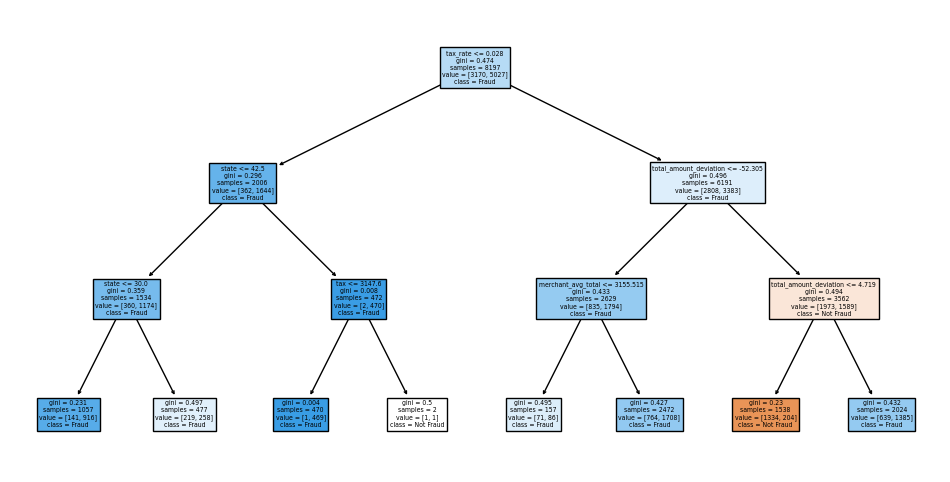

Model Accuracy: 0.74
Precision: 0.72
Recall: 0.95
F1-Score: 0.82
Confusion Matrix:
[[ 311  475]
 [  59 1205]]


In [47]:
# train 
model_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
model_tree.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
plot_tree(model_tree, feature_names=X.columns.tolist(), class_names=['Not Fraud', 'Fraud'], filled=True)
plt.show()

# predict
y_pred_tree = model_tree.predict(X_test)
#print(y_pred_tree)

# accuracy
accuracy = model_tree.score(X_test, y_test)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
conf_matrix = confusion_matrix(y_test, y_pred_tree)

print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: How many predicted fraud were actually fraud, TP / all positives

Recall: How many actual fraud were correctly detected,  TP / TP + FN

Confusion Matrix: Shows (going across) TP, FP, TN, FN

The tree chooses top 3 most influential features:
- description_similarity
- tax_rate
- state
- duplicate_line_items

compare with higher maxdepth

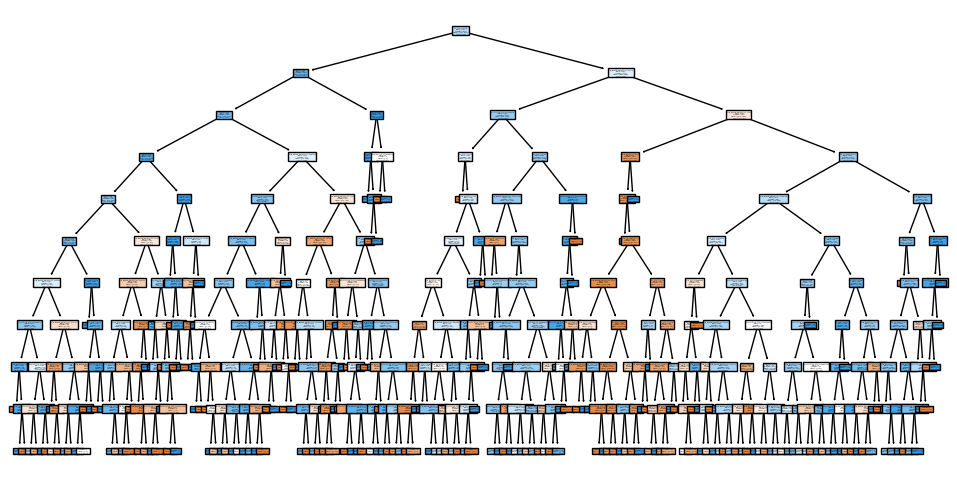

Model Accuracy: 0.73
Precision: 0.74
Recall: 0.88
F1-Score: 0.80
Confusion Matrix:
[[ 388  398]
 [ 147 1117]]


In [48]:
# train decision tree
model_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
model_tree.fit(X_train, y_train)

# plot
plt.figure(figsize=(12, 6))
plot_tree(model_tree, feature_names=X.columns.tolist(), class_names=['Not Fraud', 'Fraud'], filled=True)
plt.show()

# predict
y_pred_tree = model_tree.predict(X_test)

# accuracy
accuracy = model_tree.score(X_test, y_test)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
conf_matrix = confusion_matrix(y_test, y_pred_tree)

print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

In [44]:
# Train Logistic Regression Model
model_logreg = LogisticRegression(max_iter=1000, random_state=42)
model_logreg.fit(X_train, y_train)

# Make predictions
y_pred = model_logreg.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.66
Precision: 0.66
Recall: 0.92
F1-Score: 0.77
Confusion Matrix:
[[ 190  596]
 [  98 1166]]


In [34]:
'''
# use these two features
feature1 = 'tax_rate'
feature2 = 'grand_total'
Xplot = df2[[feature1, feature2]]
yplot = df2['label']

# normalize
scaler = StandardScaler()
Xplot_scaled = scaler.fit_transform(Xplot)

log_plot = LogisticRegression()
log_plot.fit(Xplot_scaled, yplot)

# Create a mesh grid for plotting decision boundary
x_min, x_max = Xplot_scaled[:, 0].min() - 1, Xplot_scaled[:, 0].max() + 1
y_min, y_max = Xplot_scaled[:, 1].min() - 1, Xplot_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on the grid
Z = log_plot.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Scatter plot of actual data points
sns.scatterplot(x=Xplot_scaled[:, 0], y=Xplot_scaled[:, 1], hue=yplot, palette={0: 'blue', 1: 'red'})

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Logistic Regression Decision Boundary")
plt.legend(['Real', 'Fraud'])
plt.show()
'''

'\n# use these two features\nfeature1 = \'tax_rate\'\nfeature2 = \'grand_total\'\nXplot = df2[[feature1, feature2]]\nyplot = df2[\'label\']\n\n# normalize\nscaler = StandardScaler()\nXplot_scaled = scaler.fit_transform(Xplot)\n\nlog_plot = LogisticRegression()\nlog_plot.fit(Xplot_scaled, yplot)\n\n# Create a mesh grid for plotting decision boundary\nx_min, x_max = Xplot_scaled[:, 0].min() - 1, Xplot_scaled[:, 0].max() + 1\ny_min, y_max = Xplot_scaled[:, 1].min() - 1, Xplot_scaled[:, 1].max() + 1\nxx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),\n                     np.linspace(y_min, y_max, 200))\n\n# Predict on the grid\nZ = log_plot.predict(np.c_[xx.ravel(), yy.ravel()])\nZ = Z.reshape(xx.shape)\n\n# Plot decision boundary\nplt.figure(figsize=(8, 6))\nplt.contourf(xx, yy, Z, alpha=0.3, cmap=\'coolwarm\')\n\n# Scatter plot of actual data points\nsns.scatterplot(x=Xplot_scaled[:, 0], y=Xplot_scaled[:, 1], hue=yplot, palette={0: \'blue\', 1: \'red\'})\n\nplt.xlabel(feature1)\nplt.y